In [2]:
print('hellow world')

hellow world


In [11]:
import numpy as np

In [1]:
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

from sklearn.ensemble import (
    RandomForestClassifier, 
    ExtraTreesClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
)

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from xgboost import XGBClassifier


In [2]:
df = pd.read_csv("data/bigboy.csv")

In [3]:
x = df[['cosine_feature', 'count_feature', 'hr_std', 'hr_mean', 'time_feature']]
y = df['psg_label']

In [7]:
x, y

(       cosine_feature  count_feature  hr_feature  time_feature
 0           -0.258819      38.634412    0.524519      0.000000
 1           -0.260926      31.640606    0.514774      0.008333
 2           -0.263031      22.570999    0.497230      0.016667
 3           -0.265135      19.341522    0.489079      0.025000
 4           -0.267238      21.960207    0.482398      0.033333
 ...               ...            ...         ...           ...
 22862       -0.751840       0.000000    0.130491      7.750000
 22863       -0.750400       0.000000    0.134184      7.758333
 22864       -0.748956       0.000000    0.138695      7.766667
 22865       -0.747508       0.000000    0.142484      7.775000
 22866       -0.746057       0.000000    0.148858      7.783333
 
 [22867 rows x 4 columns],
 0        0
 1        0
 2        0
 3        0
 4        0
         ..
 22862    5
 22863    5
 22864    5
 22865    5
 22866    5
 Name: psg_label, Length: 22867, dtype: int64)

In [8]:
# List discrete values in y

y.unique()

array([0, 1, 2, 3, 5])

In [9]:
# Count occurrences of each value in y

y.value_counts()

psg_label
2    11203
5     5030
3     3252
0     1907
1     1475
Name: count, dtype: int64

In [4]:
y.replace({5: 4}, inplace=True)

In [5]:
y.unique()

array([0, 1, 2, 3, 4])

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [7]:
x_train.shape, y_train.shape

((18293, 5), (18293,))

In [8]:
x_test.shape, y_test.shape

((4574, 5), (4574,))

In [15]:
clf = RandomForestClassifier()
clf.fit(x_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [16]:
y_pred = clf.predict(x_test)

In [17]:
clf.feature_importances_

array([0.18483928, 0.12000718, 0.23452996, 0.2399905 , 0.22063308])

In [9]:
adjacency_map = {
    0: {0, 1, 5},        # Wake (0) is adjacent to N1 (1) and REM (5)
    1: {1, 0, 2},        # N1 (1) is adjacent to Wake (0) and N2 (2)
    2: {2, 1, 3, 5},     # N2 (2) is adjacent to N1 (1), N3 (3), and REM (5)
    3: {3, 2},           # N3 (3) is adjacent to N2 (2)
    5: {5, 2, 0}         # REM (5) is adjacent to N2 (2) and Wake (0)
}

def get_adjacent_accuracy(y_true, y_pred):
    # Convert to list/array if they are pandas Series
    y_true = np.array(list(y_true))
    y_pred = np.array(list(y_pred))
    
    correct_count = 0
    total_count = len(y_true)
    
    for t, p in zip(y_true, y_pred):
        if p in adjacency_map.get(t, {t}):
            correct_count += 1
            
    return correct_count / total_count

In [12]:
import os
import joblib

# Create a directory to save the models
models_dir = "saved_models"

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Custom class weights to penalize misclassifying Deep Sleep (3) as Light Sleep (0, 1, 2)
# We want HIGH PRECISION for 0, 1, 2.
# This means we want to avoid False Positives for 0, 1, 2.
# A False Positive for 1 means it was actually 3, but we guessed 1.
# To fix this, we tell the model: "It is VERY BAD to get class 3 wrong."
# So we increase the weight of class 3.
class_weights = {
    0: 1,  # Wake
    1: 1,  # N1
    2: 1,  # N2
    3: 2,  # N3 (Deep Sleep) - Make this "heavier" so the model is scared to misclassify it
    4: 1   # REM
}

algorithms = {
    'Random Forest': RandomForestClassifier(class_weight=class_weights, n_estimators=200, min_samples_leaf=5),
    'Extra Trees': ExtraTreesClassifier(class_weight=class_weights, n_estimators=200, min_samples_leaf=5),
    # 'AdaBoost': AdaBoostClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Logistic Regression': LogisticRegression(class_weight=class_weights),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000),
    'XGBoost': XGBClassifier()
}

for name, clf in algorithms.items():
    clf.fit(x_train, y_train)

    y_pred = clf.predict(x_test)
    exact_score = clf.score(x_test, y_test)
    adj_score = get_adjacent_accuracy(y_test, y_pred)
    print(f"{name:<20} | {exact_score:.4f}     | {adj_score:.4f}")

    # Save the model
    model_filename = os.path.join(models_dir, f"{name.replace(' ', '_')}.joblib")
    joblib.dump(clf, model_filename)
    print(f"Saved {name} to {model_filename}")
    # print(f"{name}: {clf.features_}")
    # print(f"{name}: {clf.feature_importances_}")

Random Forest        | 0.7871     | 0.8885
Saved Random Forest to saved_models\Random_Forest.joblib
Extra Trees          | 0.7442     | 0.8610
Saved Extra Trees to saved_models\Extra_Trees.joblib
Gradient Boosting    | 0.6633     | 0.8078
Saved Gradient Boosting to saved_models\Gradient_Boosting.joblib


c:\Users\Kaito\Desktop\actually-good-alarm\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression  | 0.5654     | 0.7551
Saved Logistic Regression to saved_models\Logistic_Regression.joblib
K-Nearest Neighbors  | 0.7549     | 0.8660
Saved K-Nearest Neighbors to saved_models\K-Nearest_Neighbors.joblib
Neural Network       | 0.6563     | 0.7978
Saved Neural Network to saved_models\Neural_Network.joblib
XGBoost              | 0.7564     | 0.8771
Saved XGBoost to saved_models\XGBoost.joblib


In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler

In [14]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Save the scaler
scaler_filename = os.path.join(models_dir, "scaler.joblib")
joblib.dump(scaler, scaler_filename)
print(f"Saved scaler to {scaler_filename}")

model = Sequential([
    Dense(64, activation='relu', input_shape=(4,)),  
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(len(y.unique()), activation='softmax')  
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


history = model.fit(x_train_scaled, y_train, 
                    epochs=100, 
                    batch_size=32, 
                    validation_split=0.2,
                    verbose=0)

# Evaluate
test_loss, test_accuracy = model.evaluate(x_test_scaled, y_test, verbose=0)
print(f"Neural Network (TensorFlow): {test_accuracy:.4f}")

# Save the TensorFlow model
tf_model_filename = os.path.join(models_dir, "tensorflow_model.h5")
model.save(tf_model_filename)
print(f"Saved TensorFlow model to {tf_model_filename}")

Saved scaler to saved_models\scaler.joblib


c:\Users\Kaito\Desktop\actually-good-alarm\venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 4, but received input with shape (None, 5)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 5), dtype=float32)
  • training=True
  • mask=None
  • kwargs=<class 'inspect._empty'>

In [18]:
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns

# Function to evaluate and print metrics
def print_classification_reports(name, model, X_test, y_test, is_tf=False):
    if is_tf:
        y_pred_prob = model.predict(X_test, verbose=0)
        y_pred = np.argmax(y_pred_prob, axis=1)
    else:
        y_pred = model.predict(X_test)
        
    print(f"--- Evaluation for {name} ---")
    print(f"Cohen's Kappa: {cohen_kappa_score(y_test, y_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\n" + "="*60 + "\n")

# Evaluate all Scikit-Learn models
for name, clf in algorithms.items():
    print_classification_reports(name, clf, x_test, y_test)

# Evaluate TensorFlow model
# print_classification_reports("Neural Network (TensorFlow)", model, x_test_scaled, y_test, is_tf=True)

--- Evaluation for Random Forest ---
Cohen's Kappa: 0.6773

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.69      0.73       347
           1       0.60      0.13      0.22       320
           2       0.79      0.88      0.83      2210
           3       0.79      0.82      0.81       673
           4       0.81      0.80      0.80      1024

    accuracy                           0.79      4574
   macro avg       0.75      0.66      0.68      4574
weighted avg       0.78      0.79      0.77      4574



--- Evaluation for Extra Trees ---
Cohen's Kappa: 0.6098

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.59      0.66       347
           1       0.74      0.05      0.10       320
           2       0.74      0.85      0.80      2210
           3       0.69      0.84      0.76       673
           4       0.79      0.71      0.75      1024

    accuracy       

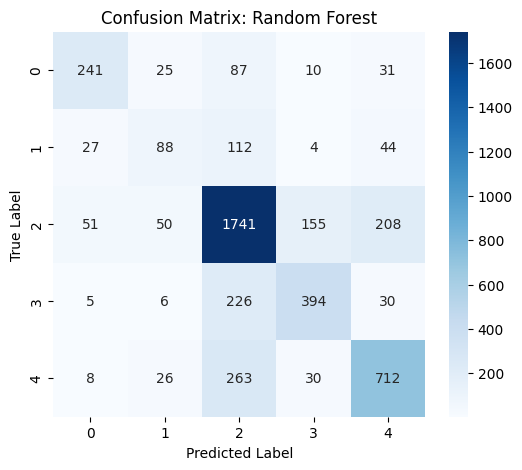

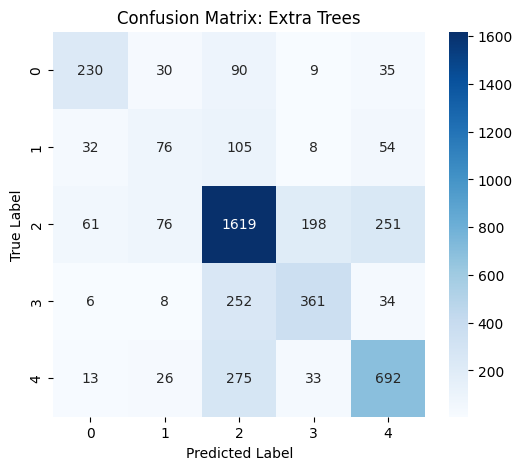

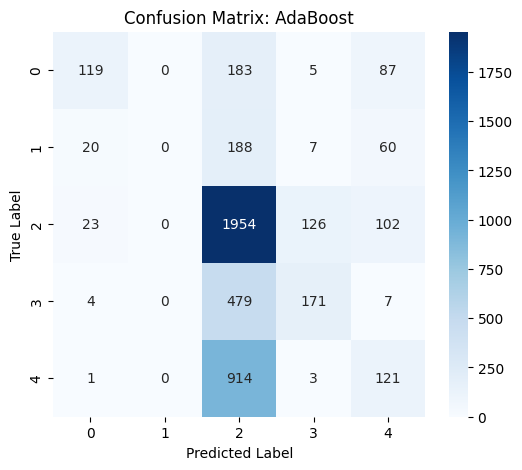

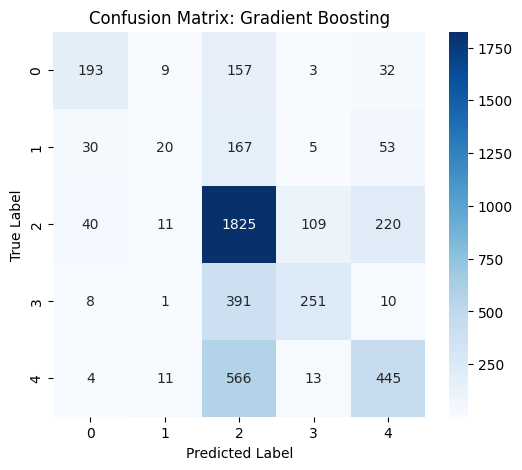

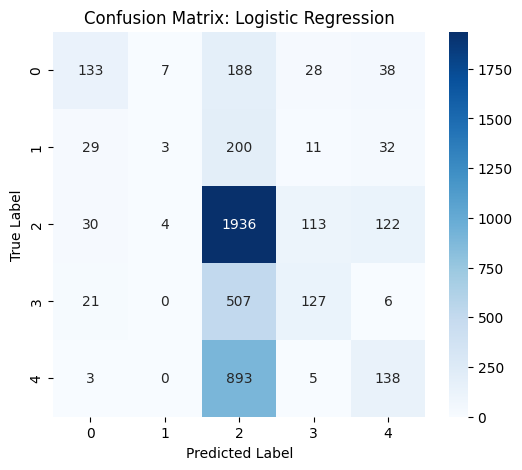

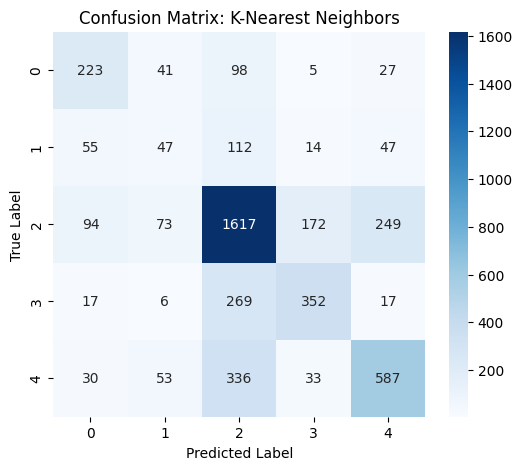

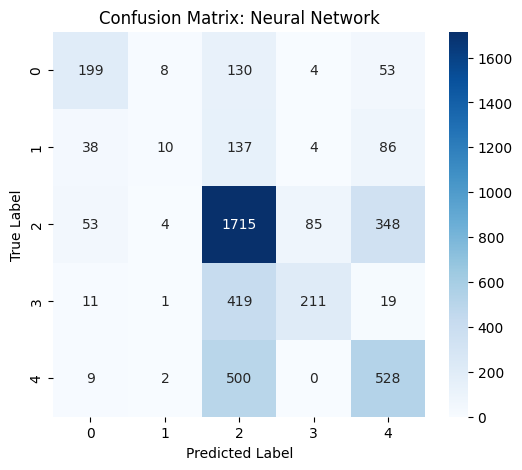

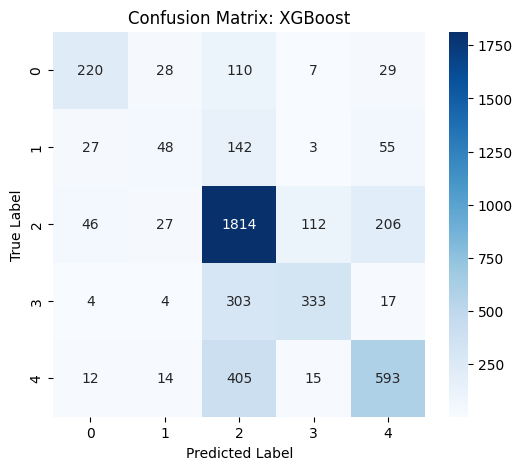

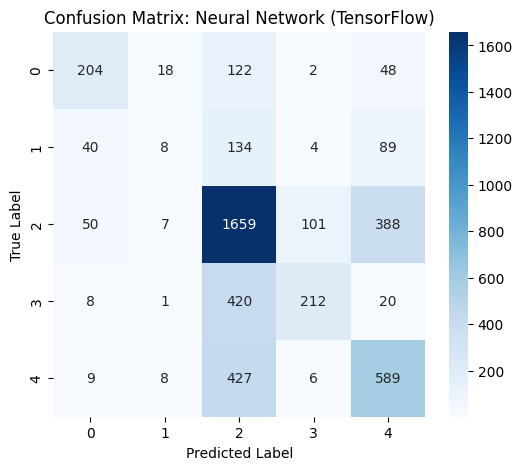

In [26]:
def plot_confusion_matrices(name, model, X_test, y_test, is_tf=False):
    if is_tf:
        y_pred_prob = model.predict(X_test, verbose=0)
        y_pred = np.argmax(y_pred_prob, axis=1)
    else:
        y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Evaluate all Scikit-Learn models
for name, clf in algorithms.items():
    plot_confusion_matrices(name, clf, x_test, y_test)

# Evaluate TensorFlow model
plot_confusion_matrices("Neural Network (TensorFlow)", model, x_test_scaled, y_test, is_tf=True)